In [1]:
import json, glob, os, sys
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sys.path.append(CODE) # set sys.path in order to load modules
from calc_util import sliding_maxnorm_ht
from adaint import integrate, default_steps_per_time, integrate2
import system #,container, setup
from scipy.integrate import odeint

In [2]:
def f(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)

    return(dI1, dM1, dR1, dI2, dM2, dR2)

In [3]:
# set parameters
 
p0=[ 0.023, 34.44, 17.7071, 0.038241, 57.9236, 1.39117, 0.000534, 
            0.016011, 14.3342,  4.33609, 0.001471, 26.1702, 45.9986, 0.79082] #only rates and ODE parameters
Ton= 1.1111111111111112
Amin=0

X0 = [0,0,0,0,0,0] #Rr, Ri, I2, M2, R2, Ra. Assume all receptor starts at Rr, which is what corresponds to the ss if Amin=0
labels=[r"$I_1$", r"$M_1$", r"$R_1$", r"$I_2$", r"$M_2$", r"$R_2$"] #should match order in X0

mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

for ht threshold 0.01, and T=15, habituation time is ht=14 stimuli, and recovery=1548.82 t.u.
for ht threshold 0.01, and T=20, habituation time is ht=22 stimuli, and recovery=1914.11 t.u.
for ht threshold 0.01, and T=25, habituation time is ht=25 stimuli, and recovery=2062.7 t.u.


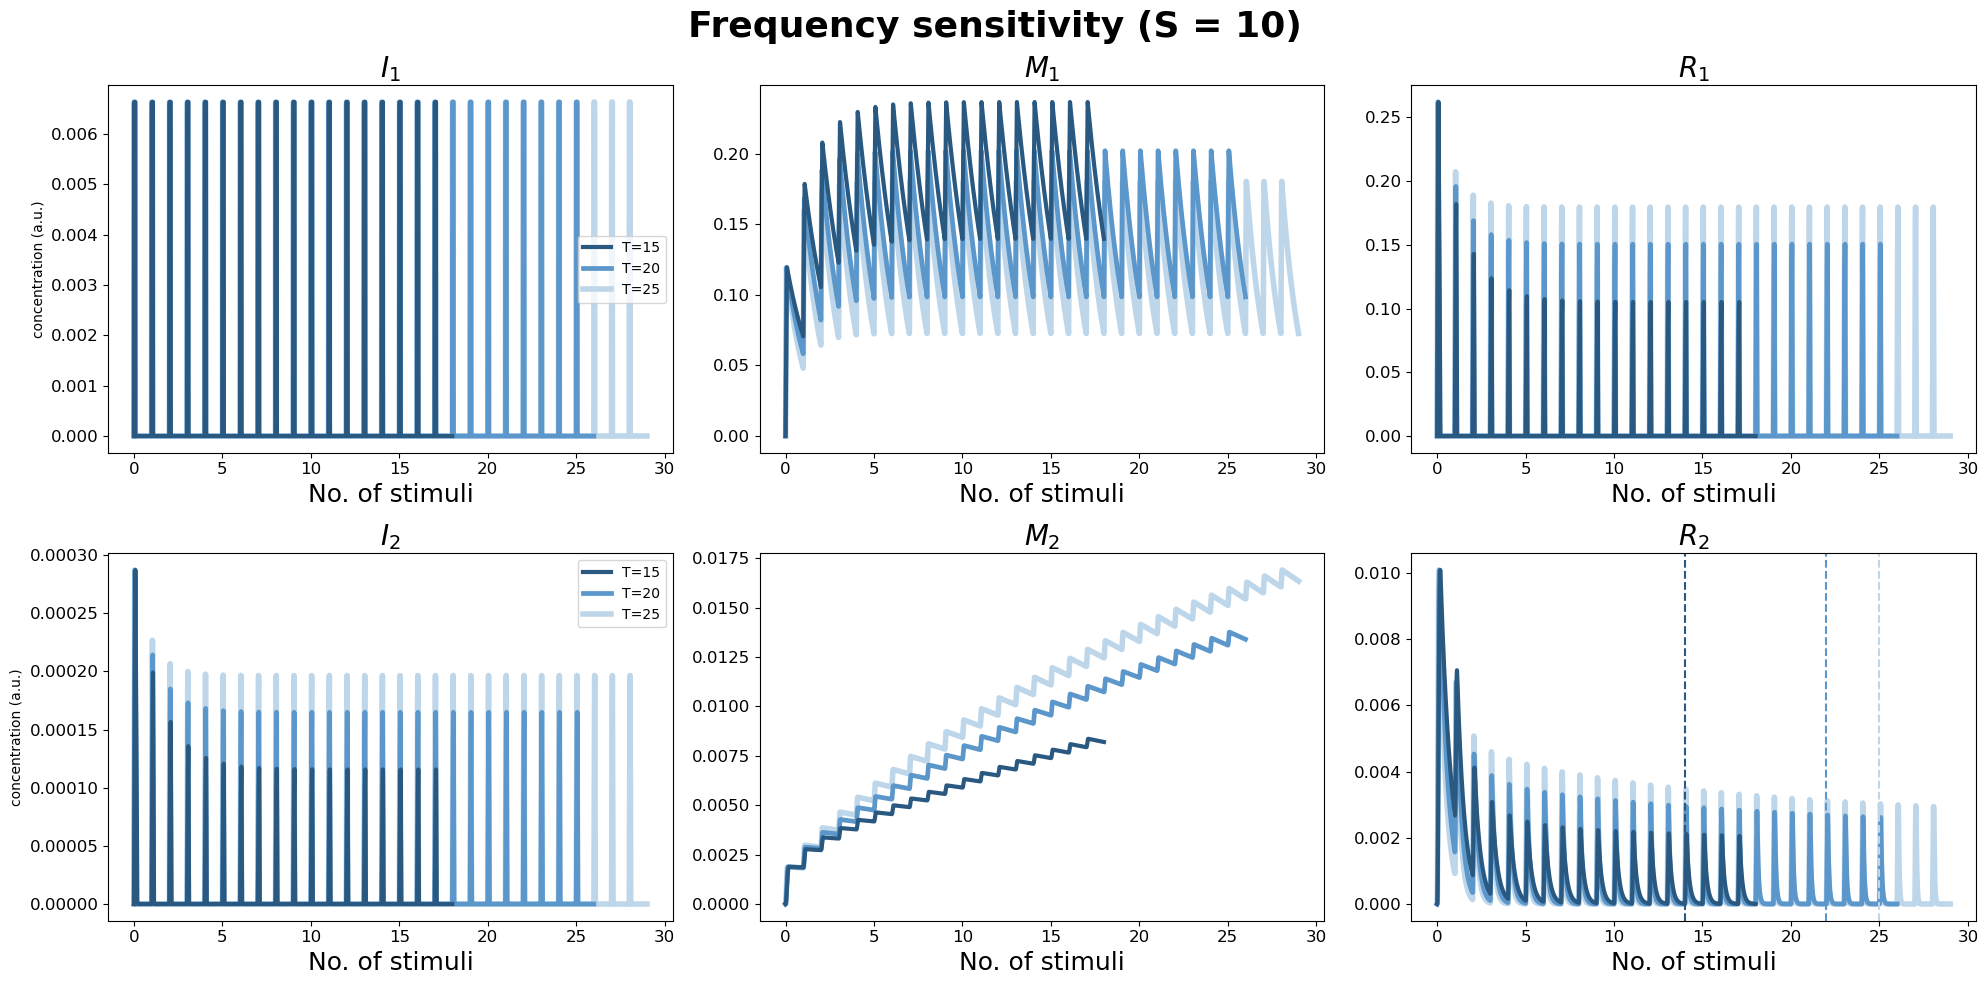

for ht threshold 0.007, and T=15, habituation time is ht=23 stimuli, and recovery=1743.29 t.u.
for ht threshold 0.007, and T=20, habituation time is ht=32 stimuli, and recovery=2058.36 t.u.
for ht threshold 0.007, and T=25, habituation time is ht=33 stimuli, and recovery=2158.5 t.u.


KeyboardInterrupt: 

In [5]:
S=10
T_scan_set = [15, 20, 25]
for ht_threshold in [0.01,0.007]:
    traj = []
    tvecs = []
    ht = []
    rt=[]
    for j, T in enumerate(T_scan_set): 
        ht_,rt_=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
        ht.append(ht_)
        rt.append(rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        
        print("for ht threshold %g, and T=%d, habituation time is ht=%d stimuli, and recovery=%g t.u."%(ht_threshold,T,ht_,rt_))
        
    
    plot=True
    if plot:
        # overlay plot for frequency sensitivity
        colors = ['#295981', '#5b97ca', '#bed6ea']
        lw = [2*1.5,2*1.7,2*2]
        al = [1.0,1.0,1.0]

        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

        for j,T in enumerate(T_scan_set):
            y = traj[j]
            tvec = tvecs[j]/T #plot with respect to stimulus number rather than time
            for k in range(0,6):
                #order of variables is #Rr, Ri, I2, M2, R2, Ra . We want to plot Rr, Ri, Ra // I2, M2, R2
                if k==0:
                    ax=axes[0][0]
                elif k==1:
                    ax=axes[0][1]
                elif k==2:
                    ax=axes[0][2] 
                elif k==3:
                    ax=axes[1][0]
                elif k==4:
                    ax=axes[1][1]
                elif k==5:
                    ax=axes[1][2]
                    ax.axvline(x=ht[j],linestyle="--",color=colors[j])
                ax.set_title(labels[k], fontsize=20)
                ax.plot(tvec, y[:,k], color=colors[j], lw=lw[j], alpha=al[j],label="T=%d"%T,zorder=(2-j))


                ax.set_xlabel('No. of stimuli', fontsize=18)
                ax.xaxis.set_tick_params(labelsize=12)
                ax.yaxis.set_tick_params(labelsize=12)

                if ax==axes[0][0] or ax==axes[1][0]:
                    ax.set_ylabel('concentration (a.u.)')
                    ax.legend()
        #sns.despine()
        fig.suptitle('Frequency sensitivity (S = %d)'%S,  fontweight="bold", fontsize=26)
        plt.tight_layout()
        plt.show()

# Recovery

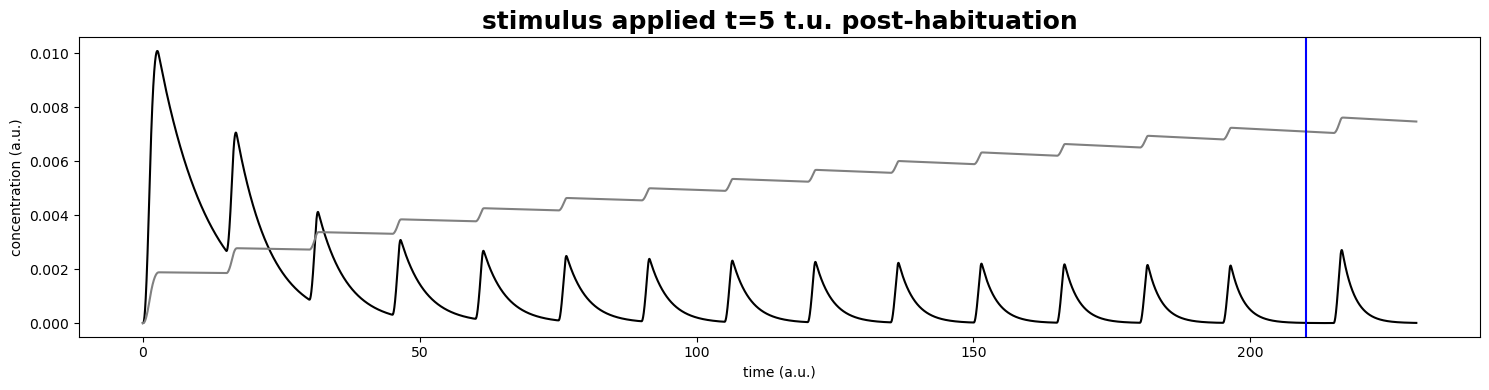

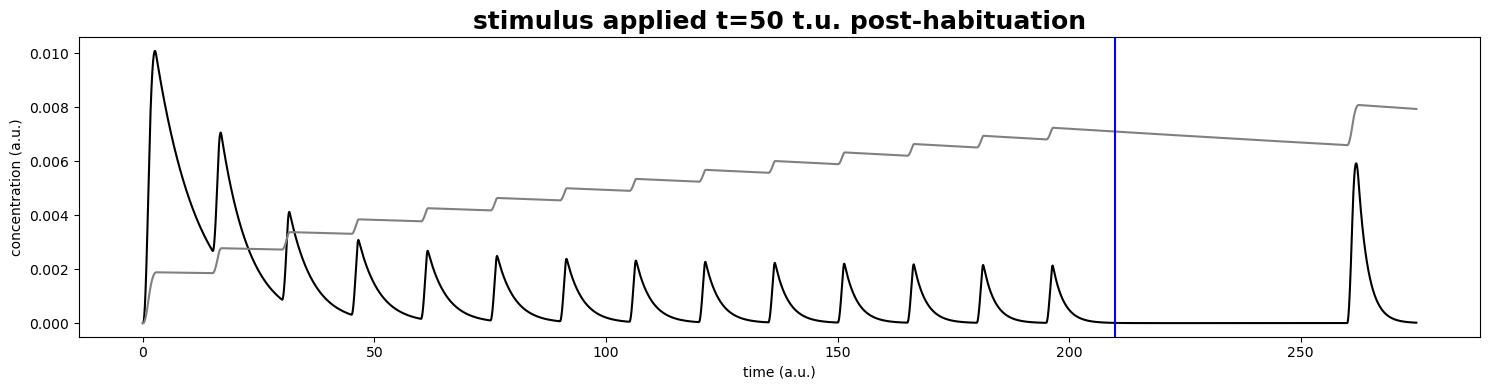

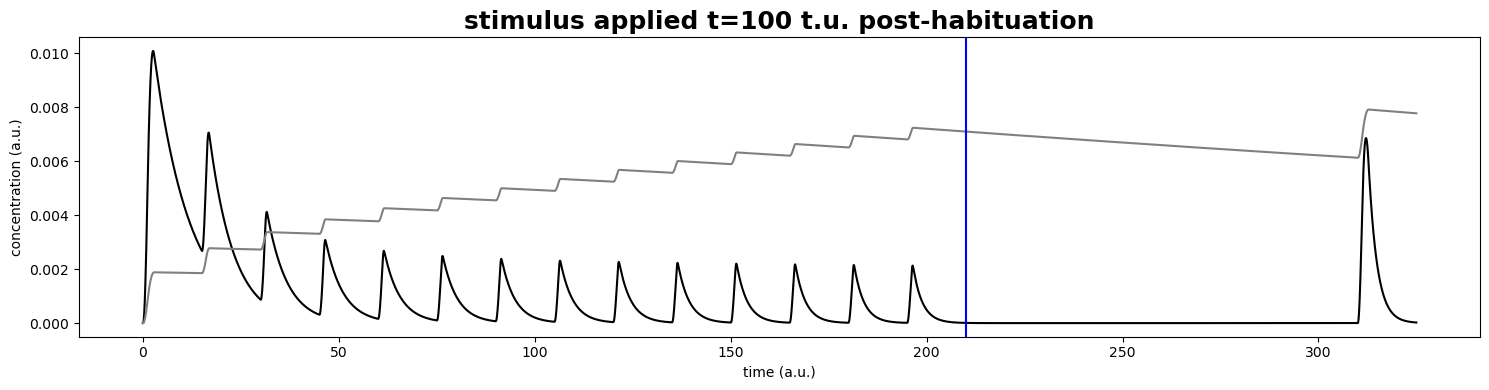

In [6]:
T=15
S=10
idxm=4 #index of the memory species
ht_threshold=0.01
tperturblist=[5,50,100] #times after habituation at which perturbation is applied, starting always from habituation time
mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
tvec=mys.computational_data["tvec"]
htstep=mys.computational_data["habituation_time_step"]
trajectory=mys.computational_data["trajectory"][:htstep,:]
habituation_time=mys.computational_data["habituation_time"]
for t in tperturblist:
    tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
    perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
    all_tvec=tvec[:htstep].copy()
    all_tvec=np.concatenate((all_tvec,tvecr))
    all_tvec=np.concatenate((all_tvec,perturbational_tvec+all_tvec[-1]))#perturbational_tvec starts at 0 and ends at T, so offset to the appropriate time
    all_traj=np.concatenate((trajectory[:,mys.output_variable],recovery_trajectory[:,mys.output_variable],perturbational_trajectory[:,mys.output_variable]))
    all_traj_M=np.concatenate((trajectory[:,idxm],recovery_trajectory[:,idxm],perturbational_trajectory[:,idxm]))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    ax.plot(all_tvec,all_traj,color="k",label="output")
    ax.plot(all_tvec,all_traj_M,color="gray",label="memory")

    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel( 'concentration (a.u.)')
    ax.axvline(x=habituation_time,color="blue")
    plt.title("stimulus applied t=%g t.u. post-habituation"%t,  fontweight="bold", fontsize=18)
    #sns.despine()
    plt.tight_layout()
    #plt.savefig(DATA+'22_06_22_7/figures/thesis_0/subliminal_overlay.pdf')
    plt.show()

# Recovery envelope

In [45]:
from scipy.signal import find_peaks
T=25
S=10
idxm=4 #index of the memory species
ht_threshold=0.01
ht, rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
tperturblist=np.linspace(5,rt,40) #times after habituation at which perturbation is applied, starting always from habituation time
tvec=mys.computational_data["tvec"]
htstep=mys.computational_data["habituation_time_step"]
trajectory=mys.computational_data["trajectory"][:htstep,:]
habituation_time=mys.computational_data["habituation_time"]
times_envelope = []
peaks_envelope = []
for t in tperturblist:
    tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
    perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
    output_var = perturbational_trajectory[:,mys.output_variable]
    peak, _ = find_peaks(output_var) #, height=0
    lista = output_var[peak]
    lista_times = perturbational_tvec[peak]
    peaks_envelope.append(lista[-1])
    
    all_tvec=tvec[:htstep].copy()
    all_tvec=np.concatenate((all_tvec,tvecr))
    times_envelope.append(lista_times[-1]+all_tvec[-1])

In [39]:
tvecr[-1]-tvecr[0] # recovery time 

1548.8099999985914

In [46]:
peak_norm = np.array(peaks_envelope)/mys.computational_data['peaks_level'][0]

In [47]:
peak_norm[-2]

0.9461536138958943

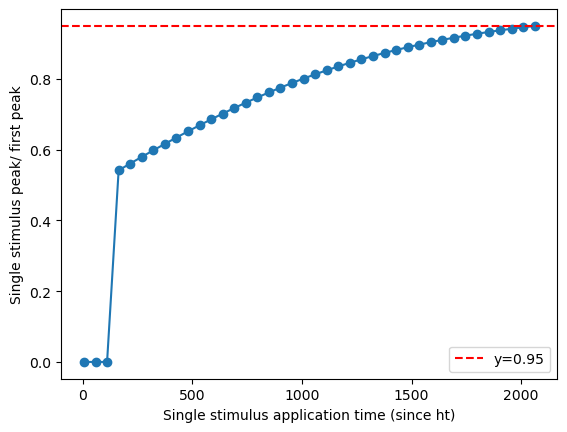

In [48]:
plt.plot(tperturblist, peak_norm, "o-")
plt.axhline(y=0.95, color="r", alpha=1.0, ls="--", label = "y=0.95")
plt.xlabel("Single stimulus application time (since ht)")
plt.ylabel("Single stimulus peak/ first peak")
plt.legend()
plt.show()

# Recovery envelope for the 3 frequencies

In [23]:
from scipy.signal import find_peaks
T_scan_set = [15, 20, 25]
S=10
idxm=4 #index of the memory species
ht_threshold=0.01
peak_norm_Ts = []
tperturblist_Ts = []

for T in T_scan_set:
    ht, rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
    #tperturblist=np.linspace(T,rt,40) #times after habituation at which perturbation is applied, starting always from habituation time
    tperturblist = np.logspace(np.log10(T), np.log10(rt), 25, endpoint=True)
    tperturblist_Ts.append(tperturblist)
    tvec=mys.computational_data["tvec"]
    htstep=mys.computational_data["habituation_time_step"]
    trajectory=mys.computational_data["trajectory"][:htstep,:]
    habituation_time=mys.computational_data["habituation_time"]
    times_envelope = []
    peaks_envelope = []
    for t in tperturblist:
        tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
        perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
        output_var = perturbational_trajectory[:,mys.output_variable]
        peak, _ = find_peaks(output_var, height=0.001) #, height=0
        lista = output_var[peak]
        lista_times = perturbational_tvec[peak]
        peaks_envelope.append(lista[-1])
        
        all_tvec=tvec[:htstep].copy()
        all_tvec=np.concatenate((all_tvec,tvecr))
        times_envelope.append(lista_times[-1]+all_tvec[-1])
    peak_norm = np.array(peaks_envelope)/mys.computational_data['peaks_level'][0]
    peak_norm_Ts.append(peak_norm)

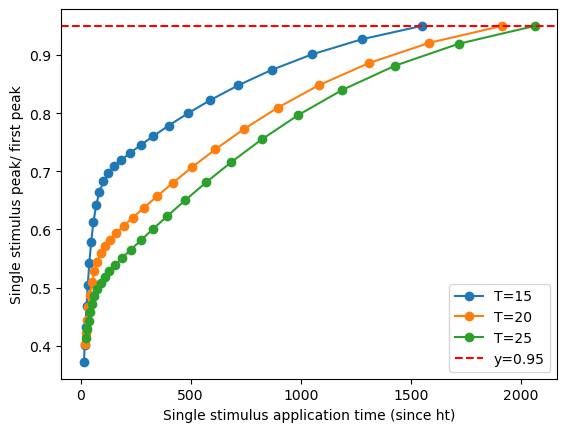

In [24]:
for j,T in enumerate(T_scan_set):
    plt.plot(tperturblist_Ts[j], peak_norm_Ts[j], "o-", label="T=%d"%T)
plt.axhline(y=0.95, color="r", alpha=1.0, ls="--", label = "y=0.95")
plt.xlabel("Single stimulus application time (since ht)")
plt.ylabel("Single stimulus peak/ first peak")
plt.legend()
plt.show()